In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/SAP Datasets.csv')

C:\Users\06pau\AppData\Local\Temp\ipykernel_13952\1121940578.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/SAP Datasets.csv')


## Data Preparation

### Merge Columns

- Combine "Indicator Name" and "Topic" to new column "Indicator Name Topic"

- Make sure there are no duplicates for "Indicator Name Topic"

### Subset Data

- Create a new data frame where you keep "Country Name", "Indicator Name Topic" and all years from 2000 to 2023 for each unique "Indicator Name Topic"

### Group Data

- For each (Country, Indicator Name Topic) create a unique regression line or any other method to fill in blanks, data is ordered by year

In [3]:
# Forward and backward filling
years_col = [str(i) for i in range(2000,2024)]
df[years_col] = df[years_col].apply(lambda row: row.ffill().bfill(), axis=1)

In [4]:
indicator_lists = df['Indicator Name'].unique().tolist()

## Temp analysis to check null indicator per country

In [13]:
# Create a new dataframe to store the count of non-null values for each country and indicator
count_df = df[['Country Name', 'Indicator Name'] + years_col].copy()

# Count the number of non-null values for each row (country and indicator) across the specified years
count_df['non_null_count'] = count_df[years_col].notnull().sum(axis=1)

# Convert the count to 1 if all years are non-null, otherwise 0
count_df['count'] = count_df['non_null_count'].apply(lambda x: 1 if x == len(years_col) else 0)

# Group by country and sum the counts
result_df = count_df.groupby('Country Name')['count'].sum().reset_index()

# Rename columns
result_df.columns = ['Country Name', 'Count']
result_df.sort_values(by='Count', ascending=True, inplace=True)



In [14]:
result_df

,Country Name,Count
183,Not classified,0
227,St. Martin (French part),11
79,Faroe Islands,14
116,Isle of Man,16
44,Channel Islands,16
...,...,...
250,Ukraine,86
203,Rwanda,86
188,Pakistan,86
18,Bangladesh,87


In [33]:
counts_country = result_df.groupby(by=['Count']).size().reset_index(name='Number of Countries')

In [34]:
counts_country

,Count,Number of Countries
0,0,1
1,11,1
2,14,1
3,16,6
4,17,1
...,...,...
58,83,10
59,84,14
60,85,16
61,86,8


In [10]:
# Group by country and sum the counts
result_df = count_df.groupby('Indicator Name')['count'].sum().reset_index()

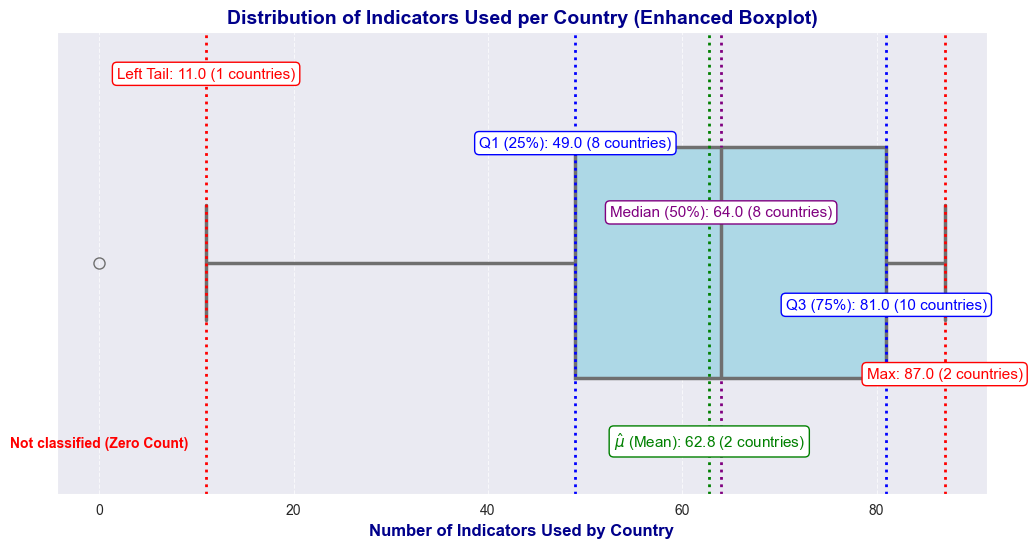

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))

ax = sns.boxplot(x=result_df['Count'], orient='h', color='skyblue', linewidth=2.5, width=0.5, fliersize=8, boxprops=dict(facecolor="lightblue"))

# Compute statistics
Q1 = result_df['Count'].quantile(0.25)
median = result_df['Count'].median()
Q3 = result_df['Count'].quantile(0.75)
mean_value = result_df['Count'].mean()
max_value = result_df['Count'].max()

# Define IQR and whiskers
IQR = Q3 - Q1
lower_whisker = result_df['Count'][result_df['Count'] >= (Q1 - 1.5 * IQR)].min()  # Left tail (lower whisker)
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = result_df[result_df['Count'] > upper_bound]  # Upper outliers

# Function to retrieve country count from counts_country
def get_country_count(value):
    row = counts_country[counts_country['Count'] == value]
    return row['Number of Countries'].values[0] if not row.empty else 0

# Label "Not Classified" if it exists
if "Not Classified" in result_df['Country Name'].values:
    not_classified_row = result_df[result_df['Country Name'] == "Not Classified"]
    plt.text(not_classified_row['Count'].values[0], 0.3, "Not Classified", fontsize=10, color='red', ha='center', fontweight='bold')

# Label the country with a count of zero if it exists
zero_count_row = result_df[result_df['Count'] == 0]
if not zero_count_row.empty:
    zero_country_name = zero_count_row['Country Name'].values[0]
    plt.text(0, 0.4, f"{zero_country_name} (Zero Count)", fontsize=10, color='red', ha='center', fontweight='bold')

# Dynamic y-offsets for spacing
y_offsets = [-0.4, -0.25, -0.1, 0.1, 0.25, 0.4]  

for i, (val, color, label) in enumerate(zip(
    [lower_whisker, Q1, median, Q3, max_value, mean_value], 
    ['red', 'blue', 'purple', 'blue', 'red', 'green'], 
    ['Left Tail', 'Q1 (25%)', 'Median (50%)', 'Q3 (75%)', 'Max', r'$\hat{\mu}$ (Mean)']
)):
    country_count = get_country_count(int(val))  
    label_text = f"{label}: {val:.1f} ({country_count} countries)" 

    plt.axvline(val, color=color, linestyle="dotted", linewidth=2)
    plt.text(val, y_offsets[i], label_text, fontsize=11, color=color, ha='center', 
             bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3'))

# Annotate outliers with country names 
for index, row in outliers.iterrows():
    plt.text(row['Count'], 0.1, row['Country Name'], fontsize=9, color='red', ha='center', rotation=30, 
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))

plt.xlabel('Number of Indicators Used by Country', fontsize=12, fontweight='bold', color='darkblue')
plt.title('Distribution of Indicators Used per Country (Enhanced Boxplot)', fontsize=14, fontweight='bold', color='darkblue')

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


In [6]:
average_count = result_df['Count'].mean()
print(average_count)


62.778195488721806


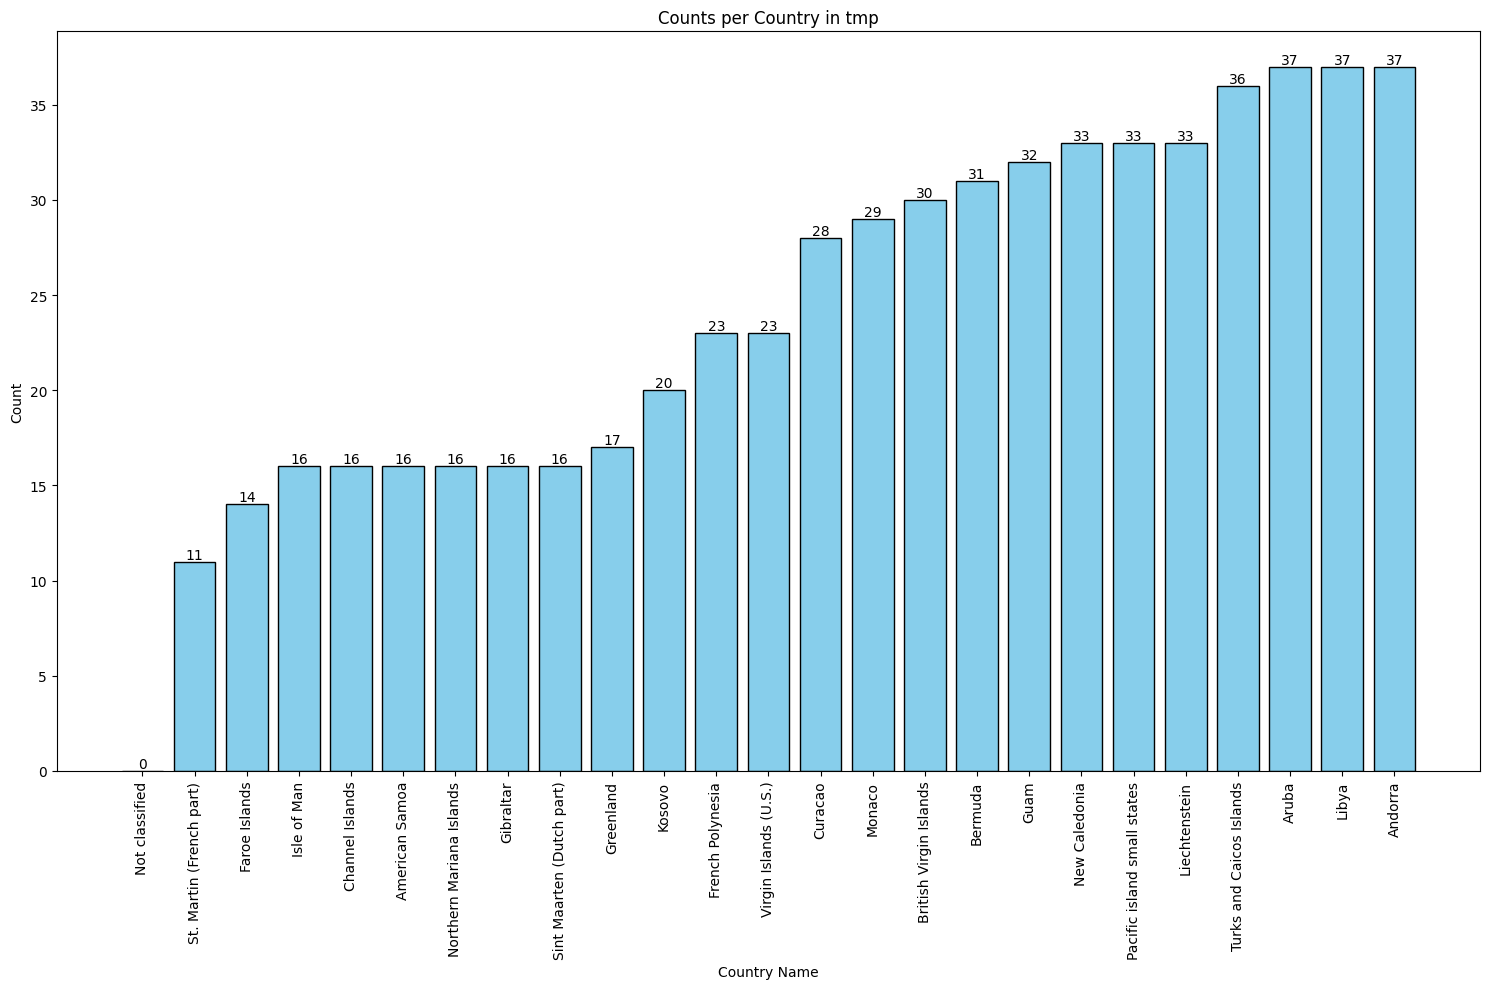

In [ ]:
import matplotlib.pyplot as plt

tmp = result_df[result_df['Count'] < 40]

plt.figure(figsize=(15, 10))
bars = plt.bar(tmp['Country Name'], tmp['Count'], color='skyblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.title('Counts per Country in tmp')
plt.xlabel('Country Name')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


## End of Temp analysis to check null indicator per country

## Temp analysis for indicators

In [8]:
# Create a new dataframe to store the count of non-null values for each indicator
indicator_count_df = df[['Indicator Name'] + years_col].copy()

# Count the number of non-null values for each row (indicator) across the specified years
indicator_count_df['non_null_count'] = indicator_count_df[years_col].notnull().sum(axis=1)

# Convert the count to 1 if all years are non-null, otherwise 0
indicator_count_df['count'] = indicator_count_df['non_null_count'].apply(lambda x: 1 if x == len(years_col) else 0)

# Group by indicator and sum the counts
indicator_result_df = indicator_count_df.groupby('Indicator Name')['count'].sum().reset_index()

# Rename columns
indicator_result_df.columns = ['Indicator Name', 'Country Count']
indicator_result_df.sort_values(by='Country Count', ascending=False, inplace=True)

In [9]:
Indicators = pd.read_csv('./data/Indicators_final.csv')
Indicators = Indicators[Indicators['DOES A HIGHER VALUE INCREASE POVERTY?'] != 'TBD']
indicator_result_df = indicator_result_df[indicator_result_df['Indicator Name'].isin(Indicators['INDICATOR NAMES'].tolist())]

In [10]:
indicator_result_df['Country Count'].describe()

count     78.000000
mean     186.025641
std       60.265856
min       35.000000
25%      138.500000
50%      201.000000
75%      235.000000
max      265.000000
Name: Country Count, dtype: float64

In [11]:
indicator_result_df['Normalized Count'] = (indicator_result_df['Country Count']) / (265)


In [12]:
indicator_result_df

,Indicator Name,Country Count,Normalized Count
18,"Age dependency ratio, young (% of working-age ...",265,1.000000
17,"Age dependency ratio, old (% of working-age po...",265,1.000000
16,Age dependency ratio (% of working-age populat...,265,1.000000
12,"Adolescent fertility rate (births per 1,000 wo...",265,1.000000
64,People using at least basic drinking water ser...,263,0.992453
...,...,...,...
30,"Children in employment, wage workers, male (% ...",90,0.339623
85,Wanted fertility rate (births per woman),81,0.305660
74,Teenage mothers (% of women ages 15-19 who hav...,77,0.290566
40,"Community health workers (per 1,000 people)",74,0.279245


In [13]:
df[df['Indicator Name'] =='Population, total'] ## removed this country because for this indicator there is one country 

,Country Name,Country Code,Indicator Name,Topic,short description,long description,Indicator Code,Unit of measure,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
22874,Africa Eastern and Southern,AFE,"Population, total",Health: Population: Structure,NaN,Total population is based on the de facto defi...,SP.POP.TOTL,0,401600588.0,412001885.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0


In [14]:
indicator_result_df.to_csv('indicator_result_df.csv', index=False)

In [ ]:
# Group by 'Country Count', count the occurrences, sort descending
grouped = indicator_result_df.groupby('Country Count').size().sort_values(ascending=False)

# Convert to DataFrame if needed
grouped_df = grouped.reset_index(name='Count')

pd.set_option('display.max_rows', None)

print(grouped_df)


    Country Count  Count
0              97      7
1             235      6
2             201      4
3             190      4
4             203      4
5             265      4
6             263      4
7             237      3
8             205      3
9              90      3
10            238      2
11            198      2
12            215      2
13            214      2
14            184      2
15            261      2
16            250      1
17            245      1
18            241      1
19            232      1
20            202      1
21            199      1
22             35      1
23            196      1
24            137      1
25             77      1
26             81      1
27            109      1
28            110      1
29            111      1
30            122      1
31            138      1
32             74      1
33            140      1
34            156      1
35            160      1
36            165      1
37            166      1
38            178      1


In [16]:
df[df['Indicator Name']=='Population, total']

,Country Name,Country Code,Indicator Name,Topic,short description,long description,Indicator Code,Unit of measure,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
22874,Africa Eastern and Southern,AFE,"Population, total",Health: Population: Structure,NaN,Total population is based on the de facto defi...,SP.POP.TOTL,0,401600588.0,412001885.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0


## End of temp analysis for indicators